"there are many available options for these design choices, leading to various trade-offs in terms of the learned representation"

- Learning the `log variance` instead of variance of the latent space encourages learning stability:
    https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig
- Expand the standard VAE to a beta one. Maybe something interesting would come up
- VAE learns representations in a small latent space. Why don't we try squeezing resnet structure inside it?

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.random as random
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import tqdm

from VAEDataLoader import BrainImageDataset, BrainRandomSampler

In [27]:
# check if the GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# VAE model

interestingly:

In forward pass, there is a step of sampling $\varepsilon$ from standard normal 
distribution. In my opinion it turns the stochastic process to a deterministic
one: from all possible generated images $\hat{x}$ given input image $x$, 
we sample only one of them, using (more or less) normally distributed latent 
variables. Without sampling the backprop won't work (that's also why we need 
reparametrization trick)
> update 20241121:\
It just looks like the model samples one of the image, in fact at 
the output of the decode nn is $\mu_{x|z}$, the mean of the distribution
$q_{\phi}(x|z)$, assumming the covariance matrix is identity.

In analogy, in reinforcement learning with MDP model, each time we sample one
sequence (so-called episode) till termination. Out of all possible outcomes,
we see only one outcome in one episode. And we trained the model based on this
outcome.

This makes me wonder: in VAE, if we **reuse** the image we trained already, 
could we dig more information from it simply by resampling? 
The resampled image from the latent space
is most likely different from the previous one, with similarities.
And the cross-entropy value should be different.

Furthermore, in classification problem, when we choose the most probable class
from the softmaxed linear output layer as the label, we are also "sampling", 
i.e. turning stochastic into deterministic. 
However, in the learning phase we kept the stochasticity in cross entropy.

In [3]:
class Coder(nn.Module):
    def __init__(self):
        super(Coder, self).__init__()
        self.coder = nn.Sequential()

    def construct_layers(self):
        raise NotImplementedError

    def forward(self, x):
        return self.coder(x)

class LinearCoder(Coder):
    def __init__(self, input_size, hidden_size, output_size):
        super(LinearCoder, self).__init__()
        self.layers = [input_size] + hidden_size + [output_size]
        self.construct_layers()

    def construct_layers(self):
        layers = self.layers
        for i in range(len(layers) - 1):
            self.coder.add_module(f'fc{i}', nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:
                self.coder.add_module(f'relu{i}', nn.ReLU())

class ConvCoder(nn.Module):
    def __init__(self, input_channels, output_channels,
                 input_size,  output_size):
        assert input_size % 4 == 0
        super(ConvCoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(input_size, hidden_size[0], 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size[0], hidden_size[1], 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_size[1], output_size, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.encode(x)

# unit test for linear coder
def test_linear_coder():
    coder = LinearCoder(100, [100, 50, 25], 10)
    x = torch.randn(100)
    y = coder(x)
    assert y.shape == (10,)
test_linear_coder()

In [ ]:
class VariationalAutoEncoder(nn.Module):
    """ implementation of the Variational AutoEncoder

    Args:
        - device: the device to run the model on
        - input_size: the size of the input data
        - hidden_size: the size of the hidden layer
        - z_space_size: the size of the latent space
    """

    def __init__(self, device,
                 input_size: int,
                 hidden_size: list[int] = [100, 50, 25],
                 latent_space_size: int = 10,
                 ) -> None:
        super(VariationalAutoEncoder, self).__init__()

        self.device = device
        self.input_size = input_size

        # encoder: from x to two channels: mean and log_var
        self.encoder = LinearCoder(input_size**2, hidden_size[:-1], hidden_size[-1])

        # mean and logvariance layers from the input to the latent space
        linear_size = hidden_size[-1]

        self.mean_layer = nn.Linear(linear_size, latent_space_size)
        self.logvar_layer = nn.Linear(linear_size, latent_space_size)

        # decoder: from z to x
        self.decoder = LinearCoder(latent_space_size, hidden_size[::-1], input_size**2)


    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)


    # reparameterization trick, the randomness is pushed outside the network
    # z = mu + sigma * epsilon, where epsilon ~ N(0, 1)
    def reparameterize(self, mean, log_var):
        # similar to mean, epsilon is in fact a vector of
        # size of the latent space
        epsilon = torch.randn_like(mean).to(self.device)
        std = torch.exp(0.5 * log_var)
        # return the latent space vector
            # here the variance is also modeled as a vector, mathematically it
            # should be a diagonal matrix and epsilon should be matrix
            # multiplied with the variance matrix
        z = mean +  std * epsilon
        return z

    def forward(self, x):
        # put everything together
        x = x.view(-1, 1, self.input_size**2)
        x = self.encode(x)
        mean = self.mean_layer(x)
        log_var = self.logvar_layer(x)

        z = self.reparameterize(mean, log_var)
        x_hat = self.decode(z)
        x_hat = x_hat.view(-1, 1, self.input_size, self.input_size)
        return x_hat, mean, log_var

In [8]:
model = VariationalAutoEncoder(device, 28)
from torchsummary import summary
summary(model, batch_size = 64, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [64, 1, 100]          78,500
              ReLU-2               [64, 1, 100]               0
            Linear-3                [64, 1, 50]           5,050
              ReLU-4                [64, 1, 50]               0
            Linear-5                [64, 1, 25]           1,275
       LinearCoder-6                [64, 1, 25]               0
            Linear-7                [64, 1, 10]             260
            Linear-8                [64, 1, 10]             260
            Linear-9                [64, 1, 25]             275
             ReLU-10                [64, 1, 25]               0
           Linear-11                [64, 1, 50]           1,300
             ReLU-12                [64, 1, 50]               0
           Linear-13               [64, 1, 100]           5,100
             ReLU-14               [64,

# Loss function

reconstruction: the ability to copy the original image
Sample only once
$$E_{q_{\phi}(z|x)}[log (p_{\theta}(x|z))] -> log(p_{\theta}(x|z))$$


In [ ]:
# reconstruction loss ()) - beta KL divergence (regularization)

class ELBO(nn.Module):
    def __init__(self, beta=1):
        super(ELBO, self).__init__()
        self.beta = beta

    def forward(self, x_hat, x, mean, log_var):
        """
        Args:
            - x_hat: the reconstructed data (mean of the Gaussian p(x|z))
            - x: the original data
            - mean: the mean of the latent space
            - log_var: the log variance of the latent space
            - beta: the regularization parameter
        """
        # reconstruction loss
        # since the input is not binary, we use the mean squared error
        MSE = nn.MSELoss(reduction='sum')
        reconstruction_loss = MSE(x_hat, x)
        # KL divergence between the conditional distribution of the latent space
        # p(z|x) and the prior distribution p(z) = N(0, 1)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        # print(reconstruction_loss, kl_divergence)
        return (reconstruction_loss + self.beta * kl_divergence)

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss =nn.MSELoss(reduction='sum')
    reproduction_loss = reproduction_loss(x_hat, x)
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

# Training on other dataset

In [28]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

dataset_path = "./"
batch_size = 128
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [35]:
# learning rate
lr = 1e-3
# number of epochs
epochs = 30

beta = 1
# create the model
model = VariationalAutoEncoder(device, input_size=28, hidden_size=[400], latent_space_size=200)
# Adam optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# ELBO loss
criterion = ELBO(beta=beta)

# train the model
dict_log = train(model, optimizer, epochs, train_loader, test_loader, criterion, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

# Training

In [12]:
# copied from DL course
def train_one_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    loss_step = []
    for data in tqdm(train_loader, leave=False, desc="Training"):
        inp_data = data[0]
        inp_data = inp_data.to(device)
        output_data, mean, log_var = model(inp_data)
        loss = criterion(output_data, inp_data, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_step.append(loss.item())
    loss_curr_epoch = np.mean(loss_step)
    return loss_curr_epoch

def validate(model, val_loader, criterion, device):
    model.eval()
    correct, total = 0, 0
    loss_step = []
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Validating", leave=False):
            inp_data = data[0]
            inp_data = inp_data.to(device)
            output_data, mean, log_var = model(inp_data)
            val_loss = criterion(output_data, inp_data, mean, log_var)
            loss_step.append(val_loss.item())
        val_loss_epoch = np.mean(loss_step)
        return val_loss_epoch

def save_model(model, path, epoch, optimizer, val_loss):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': val_loss,
        }, path)

def train(model, optimizer, num_epochs, train_loader, val_loader, criterion, device):
    dict_log = {"train_loss":[], "val_loss":[]}
    best_val_loss = 1e8
    best_val_acc = 0
    model = model.to(device)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        loss_curr_epoch = train_one_epoch(model, optimizer, train_loader, criterion, device)
        val_loss = validate(model, val_loader, criterion, device)

        # Print epoch results to screen
        msg = (f'Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}')
        pbar.set_description(msg)

        dict_log["train_loss"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)

        # save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, f'best_model_min_val_loss.pth', epoch, optimizer, val_loss)
    return dict_log

In [46]:
# Training the model
batch_size = 128
tile_size = 64

training_data = BrainImageDataset(train=True)
test_data = BrainImageDataset(train=False)

training_sampler = BrainRandomSampler(training_data, tile_size, batch_size)
test_sampler = BrainRandomSampler(test_data, tile_size, batch_size)

train_loader = DataLoader(training_data, batch_sampler=training_sampler)
test_loader = DataLoader(test_data, batch_sampler=test_sampler)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './cell_data.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [36]:
# learning rate
lr = 1e-2
# number of epochs
epochs = 150

beta = 3
# create the model
model = VariationalAutoEncoder(device, input_size=64, latent_space_size=128)
# Adam optimizer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# ELBO loss
criterion = ELBO(beta=beta)

# train the model
dict_log = train(model, optimizer, epochs, train_loader, test_loader, criterion, device)


  0%|          | 0/150 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validating:   0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

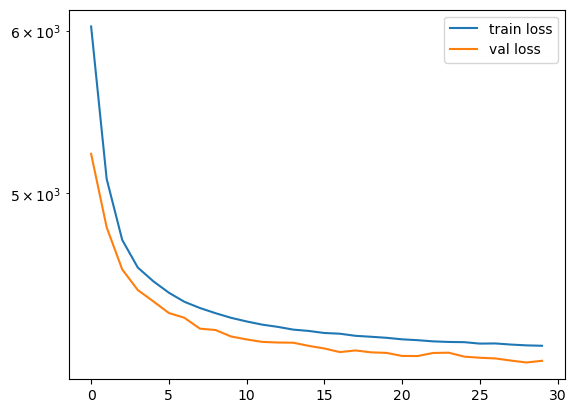

In [36]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(dict_log["train_loss"], label="train loss")
plt.plot(dict_log["val_loss"], label="val loss")
# log scale
plt.yscale("log")
plt.legend()
plt.show()


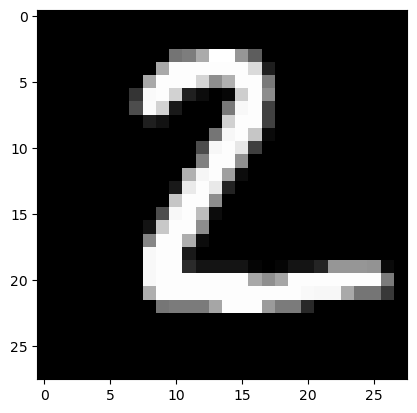

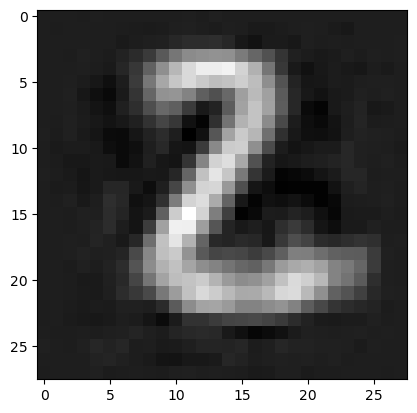

In [40]:
# plot a sample image from the model
model.eval()
img = next(iter(test_loader))[0].to(device)
output, _, _ = model(img)

# plot the original image
plt.imshow(img[1].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

# plot the reconstructed image
plt.imshow(output[1].cpu().detach().numpy().reshape(28, 28), cmap='gray')
plt.show()


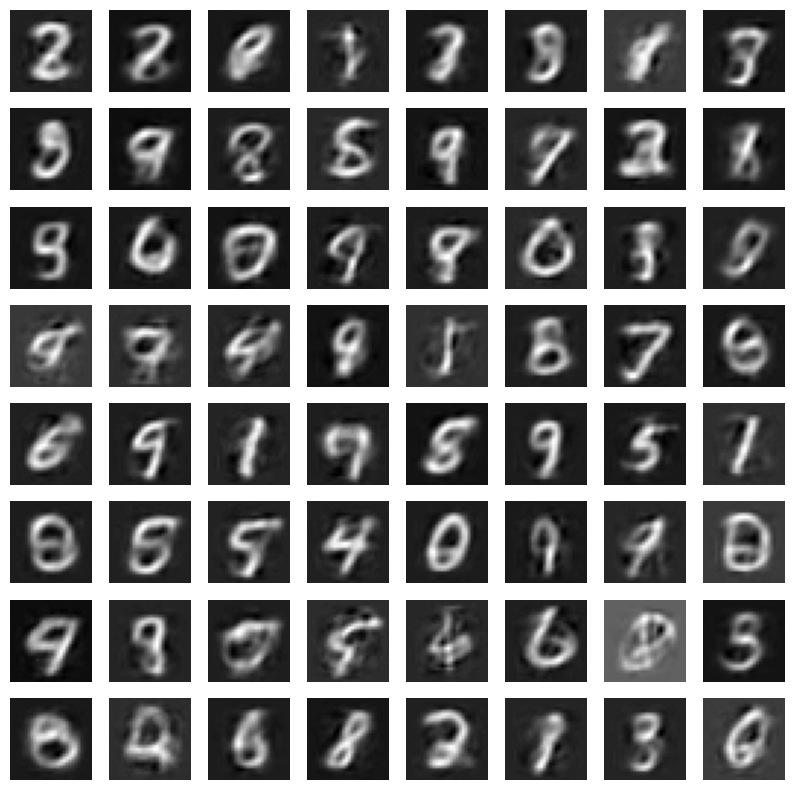

In [45]:
with torch.no_grad():
    noise = torch.randn(128, 200).to(device)
    generated_images = model.decode(noise)

    # plot the generated images
    fig, ax = plt.subplots(8, 8, figsize=(10, 10))
    for i in range(8):
        for j in range(8):
            ax[i, j].imshow(generated_images[i*8+j].cpu().detach().numpy().reshape(28, 28), cmap='gray')
            ax[i, j].axis('off')